This is an attempt to deskew written test documents (very useful in OCR)

In [50]:
import skimage.io as io
import skimage.morphology as morphology
from scipy.signal import correlate2d
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from skimage.morphology import skeletonize
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from commonfunctions import *

import numpy as np 
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Input image has to be borderless!


In [51]:
def findContour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 7, 17, 17)
 
    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)
   
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
    NumberPlateCnt = None 


    for c in cnts:
            peri = cv2.arcLength(c, closed= True)
            approx = cv2.approxPolyDP(c, epsilon=0.02 * peri, closed=True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w].copy()
                show_images(images=[img, ROI])
                return (NumberPlateCnt, ROI)
    return None, None


In [52]:
def distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)
def calculate_left_right_points(corner_points):
    print(corner_points)
    # Highest y-coordinate
    bottom_most_idx = 0
    max_y = 0
    
    for idx, point in enumerate(corner_points):
        x, y = point
        if y > max_y:
            bottom_most_idx = idx
            max_y = y
    
    # identify previous and next points in the corner list [0,1,2,3]
    prev_idx = bottom_most_idx - 1 if bottom_most_idx > 0 else 3
    next_idx = bottom_most_idx + 1 if bottom_most_idx < 3 else 0
    
    distance_to_prev = distance(corner_points[bottom_most_idx], corner_points[prev_idx])
    distance_to_next = distance(corner_points[bottom_most_idx], corner_points[next_idx])
    

    if distance_to_prev > distance_to_next:
        # If previous point is further, compare x-coordinates to determine left and right  --------------------------
        if corner_points[prev_idx][0] < corner_points[bottom_most_idx][0]:               #                          -
            left_idx, right_idx = prev_idx, bottom_most_idx                              #                          -
        else:
            left_idx, right_idx = bottom_most_idx, prev_idx
    else:
        if corner_points[next_idx][0] < corner_points[bottom_most_idx][0]:
            left_idx, right_idx = next_idx, bottom_most_idx
        else:
            left_idx, right_idx = bottom_most_idx, next_idx
    

    return left_idx, right_idx




In [53]:
"""
    find rotation angle 
      Args:
        left_x (float): The x-coordinate of the first point.
        right_x (float): The x-coordinate of the second point.
        left_y (float): The y-coordinate of the first point.
        right_y (float): The y-coordinate of the second point.

    Returns:
        float: The angle in degrees, calculated using the sine of the angle.
"""
def find_rotation_angle(left_x, right_x, left_y, right_y):
    opp = right_y - left_y
    hyp = ((left_x - right_x) ** 2 + (left_y - right_y) ** 2) ** 0.5
    sin = opp / hyp
    theta = math.asin(sin) * (180 / math.pi)
    return theta


In [54]:
def deskew_img(cropped_img, contour):
    if contour is None:
        return cropped_img
    contour =  [item for sublist in contour for item in sublist]
    
    left, right = calculate_left_right_points(corner_points=contour)
    left_x=contour[left][0]
    left_y=contour[left][1]
    right_x=contour[right][0]
    right_y=contour[right][1]
    angle = find_rotation_angle(left_x, right_x, left_y, right_y)
    if angle > 20: return cropped_img
    image_center = tuple(np.array(cropped_img.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0) #no scale
    result = cv2.warpAffine(cropped_img, rot_mat, cropped_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    show_images(images=[cropped_img, result])
    return result

  


In [55]:
def removeBorder(image, threshold_window=11, c=2, resize_dim=(500, 300), kernel_size=3):
    """
    Removes borders from an image and ensures edges are connected.
    
    Args:
        image: Input image (color or grayscale).
        threshold_window: Size of the adaptive thresholding window.
        c: Constant to subtract in adaptive thresholding.
        resize_dim: Tuple (width, height) to resize the image. If None, no resizing.
        kernel_size: Size of the kernel for morphological operations.
    
    Returns:
        Cropped image with borders removed.
    """
    image = imutils.resize(image, width=500)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)
   

    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
    NumberPlateCnt = None 

    if resize_dim:
        image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
    
    # Convert to grayscale if needed
    im_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Apply median blur to reduce noise
    im_gs = cv2.medianBlur(im_gs, kernel_size)
    
    # Adaptive thresholding
    img_bordered = cv2.adaptiveThreshold(
        im_gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, threshold_window, c
    )
    
    # Morphological closing to connect edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    img_bordered = cv2.morphologyEx(img_bordered, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Add border to ensure contours near the edges are not missed
    img_bordered = cv2.copyMakeBorder(
        img_bordered, 10, 10, 10, 10, borderType=cv2.BORDER_CONSTANT, value=0
    )
    io.imshow(img_bordered)
   
    contours, _ = cv2.findContours(img_bordered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found.")
        return image  
    
    largest_contour = max(contours, key=cv2.contourArea)
    

    x, y, w, h = cv2.boundingRect(largest_contour)
    
 
    cropped = image[y:y+h, x:x+w]
    
    return cropped


In [56]:

def deskew(im, max_skew=10):
    """
    Deskews the input image based on detected line angles.

    Args:
        im: Input image (color or grayscale).
        max_skew: Maximum skew angle (degrees) to consider for deskewing.

    Returns:
        Deskewed image.
    """
    # Convert to grayscale if the image is not already
    if len(im.shape) > 2:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Step 1: Denoise using median filter
    smoothed = cv2.medianBlur(im, 5)

    # Step 2: Apply adaptive thresholding to create a binary image
    binary = cv2.adaptiveThreshold(
        smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Step 3: Detect edges using Sobel gradients
    edges = cv2.Canny(binary, 50, 150)

    # Step 4: Detect lines using Hough Transform
    height, width = edges.shape
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, 200, minLineLength=width / 12, maxLineGap=width / 150
    )

    if lines is None or len(lines) == 0:
        print("No lines detected. Returning original image.")
        return im

    # Step 5: Collect line angles
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)

    # Step 6: Filter angles to remove outliers
    angles = [angle for angle in angles if abs(angle) <= max_skew]

    if len(angles) < 5:
        print("Insufficient lines for deskewing. Returning original image.")
        return im

    # Step 7: Compute the median angle
    median_angle = np.median(angles)

    # Step 8: Deskew the image
    M = cv2.getRotationMatrix2D((width / 2, height / 2), median_angle, 1)
    deskewed = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)

    return deskewed


In [57]:
def thickening_image_border(image, kernel_size=3, edge_threshold=100):
    # Step 1: Convert to grayscale (if input is a colored image)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Step 2: Detect edges using Canny edge detector (this will give us the border)
    edges = cv2.Canny(gray, threshold1=edge_threshold, threshold2=edge_threshold * 2)
    
    # Step 3: Dilate the edges to thicken the border
    dilated_edges = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size)))
    
    # Step 4: Create a mask for the dilated edges (thickened border)
    mask = dilated_edges.astype(np.uint8)
    
    # Step 5: Create a result image where the inner region remains the same, but the border is thickened
    result = np.copy(image)
    
    # Set pixels in the mask to white (255) where the border is thickened
    result[mask == 255] = 255  # You can set this to the desired color
    
    return result





In [58]:
def read_letter(img, templates):
    # Resize the input image to match the template size (42x24)
    img_resized = cv2.resize(img, ( 42, 24), interpolation=cv2.INTER_AREA)
    
    # Record correlation values for each template
    record = []
    
    # Iterate over templates and compute correlation
    for template in templates:
        cor = correlate2d(img_resized, template, mode='valid')  # Compute 2D correlation
        record.append(cor.max())  # We take the maximum correlation value for each template
    
    # Find the index of the highest correlation value
    ind = np.argmax(record)
    
    # Display the result (for debugging purposes)
    print(f"Best match index: {ind}")
    
    return ind if record[ind] > 26//2 else -1

In [59]:
def extract_characters(img, templates):
    if img is None:
        return 
    img = cv2.resize(img, (0,0), fx=2, fy=2)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(img)
    
 
    lower_thresh = int(mean_intensity * 0.8)  
    upper_thresh = int(mean_intensity * 1.2)  

   
    _, binary = cv2.threshold(img, lower_thresh, upper_thresh, cv2.THRESH_BINARY_INV)
   #erosion 
    img = cv2.open(binary, np.ones((2, 2), np.uint8), iterations=1)
    show_images(images=[img, binary])

    epsilon = 0.2
    
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]

    # Calculate the median area of the contours
    median_area = np.median(areas)
    io.imshow( cv2.drawContours(img, contours, -1, (0,255,0), 3))
    characters = []
    for i, contour in enumerate(contours):
        contour= cv2.approxPolyDP(contour,4,  closed=True)
        x, y, w, h = cv2.boundingRect(contour)
     
        # Extract the area of the current contour
        area = cv2.contourArea(contour)

        # Compare the area with the median area (plus epsilon margin)
        if abs(area - median_area) <= median_area * epsilon:
            # Extract the character region from the binary image
            char = binary[y:y + h + epsilon, x:x + w + 2+epsilon]
            char = cv2.resize(char, (24, 42), interpolation=cv2.INTER_AREA)
    
            char = morphology.area_closing(char)

        else: return
        characters.append(char)
    
    return characters
def save_to_file(characters, output_dir="characters"):
    for i, char in enumerate(characters):
        print(char)
        cv2.imwrite(f"{output_dir}/char_{i}.png", char)
  


In [60]:
def sharpen_image(image):
    # Define a sharpening kernel
    kernel = np.array([[0, -1,  0],
                       [-1,  5, -1],
                       [0, -1,  0]])
    
    # Apply the kernel to the image using cv2.filter2D
    sharpened = cv2.filter2D(image, -1, kernel)
    
    return sharpened

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_license_plate(image):
    """
    Preprocess the input license plate image:
    - Resize to a fixed size
    - Convert to grayscale
    - Apply binary thresholding and morphological operations
    """
    # Step 1: Resize the image for consistency
    resized_img = cv2.resize(image, (333, 75))
    
    # Step 2: Convert to grayscale
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    
    # Step 3: Apply binary thresholding
    _, binary_img = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Step 4: Morphological operations to reduce noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary_img = cv2.erode(binary_img, kernel, iterations=1)
    binary_img = cv2.dilate(binary_img, kernel, iterations=1)
    
    # Step 5: Make borders white to avoid detecting contours near the edges
    binary_img[:3, :] = 255
    binary_img[-3:, :] = 255
    binary_img[:, :3] = 255
    binary_img[:, -3:] = 255
    show_images(images=[image,binary_img])
    return binary_img

def extract_character_contours(binary_img, numChars=6):
    """
    Extract contours from the binary image and filter them based on size.
    """
    # Define estimated dimensions for character contours
    height, width = binary_img.shape
    dimensions = {
        "min_height": height / 3,
        "max_height": height,
        "min_width": width / (numChars *2),
        "max_width": width / 3
    }
    print(dimensions)
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    
    # Draw contours (use a visible color)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Green contours
    
    show_images(images=[binary_img, contour_img])
    character_contours = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        print(x, y, w, h)
        # Filter contours based on size
        if dimensions["min_width"] <= w <= dimensions["max_width"] and dimensions["min_height"] <= h <= dimensions["max_height"]:
            character_contours.append((x, y, w, h))
    
    # Sort contours by x-coordinate to ensure left-to-right order
    character_contours = sorted(character_contours, key=lambda c: c[0])
    
    return character_contours

def segment_characters(image):
    """
    Segment characters from the license plate image.
    Returns a list of segmented character images.
    """
    # Step 1: Preprocess the image
    binary_img = preprocess_license_plate(image)
    show_images(images=[binary_img])
    # Step 2: Extract character contours
    character_contours = extract_character_contours(binary_img)

   
    # Step 3: Crop and resize individual characters
    characters = []
    for (x, y, w, h) in character_contours:
        char_img = binary_img[y:y + h, x:x + w]
        char_img_resized = cv2.resize(char_img, (42, 28))  # Resize to standard size
        characters.append(char_img_resized)
    
    return characters, character_contours

def display_segmented_characters(characters):
    """
    Display the segmented characters for visualization.
    """
    for i, char_img in enumerate(characters):
        show_images(images=[char_img])
        plt.subplot(1, len(characters), i + 1)
        plt.imshow(char_img, cmap="gray")
        plt.axis("off")
    plt.show()
def classify_chars(characters, templates):
    # Calculate Moments 
    min_dist= float("inf")
    best_match_index = -1
    res = []
    for i, char_img in enumerate(characters):
        for idx, template in enumerate(templates):
                print(template)
                dist_1 = cv2.matchShapes(char_img, template, cv2.CONTOURS_MATCH_I1, 0) *1e5
                dist_2 = cv2.matchShapes(char_img, template, cv2.CONTOURS_MATCH_I2, 0) *1e5
                dist_3 = cv2.matchShapes(char_img, template, cv2.CONTOURS_MATCH_I3, 0) *1e5
                total = dist_1 + dist_2 + dist_3
                if total < min_dist:
                    min_dist = total
                    best_match_index = idx
        res.append(best_match_index)
    return res

     



In [62]:

def train(templates, labels):
    X_train, X_test, y_train, y_test = train_test_split(templates, labels, test_size=0.2, random_state=42)
  
    # model = xgb.XGBClassifier(
    #     eval_metric="mlogloss",
    #     use_label_encoder=False,
    #     device="cuda",
    #     tree_method="gpu_hist",
    #     predictor="gpu_predictor",
    #     max_depth=2  # Reduce tree depth
    # )
    # Defining the parameters grid for GridSearchCV 
    param_grid={'C':[0.1,1,10,100], 
                'gamma':[0.0001,0.001,0.1,1], 
                'kernel':['rbf','poly', 'linear']} 
    
    # Creating a support vector classifier 
    svc=svm.SVC(probability=True) 
    
    # Creating a model using GridSearchCV with the parameters grid 
    model=GridSearchCV(svc,param_grid)
    # Train the classifier
    model.fit(X_train, y_train)    # Evaluate the model
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    return model


In [63]:
def predictKNN(knn, new_templates):
    """
    Predict the label(s) of new data using the trained k-NN model.
    
    Args:
        knn: Trained k-NN classifier.
        new_templates: New data features to predict (e.g., flattened images).
        
    Returns:
        predictions: Predicted labels for the input data.
    """
    # Predict using the k-NN model
    predictions = knn.predict(new_templates)
    return predictions

In [64]:

def calculate_hu_moments(image):
    """Calculate Hu Moments from image."""

    moments = cv2.moments(image)

    hu_moments = cv2.HuMoments(moments)
    hu_moments = np.where(hu_moments == 0, 1e-10, hu_moments)
    

    return np.log(np.abs(hu_moments)).flatten()
 



In [65]:
def extract_hog_features(image):
    features= hog(image, orientations=9, pixels_per_cell=(8, 8), 
                      cells_per_block=(2, 2), channel_axis=None)
    return features

In [66]:

def extract_zoning_features(image, grid_size=(3, 3)):
    """
    Extract zoning features from an image.
    
    Parameters:
    - image: Grayscale image (2D array).
    - grid_size: Tuple indicating the grid size (rows, cols).
    
    Returns:
    - features: 1D numpy array of zoning features.
    """
   
    zone_height = image.shape[0] // grid_size[0]
    zone_width = image.shape[1] // grid_size[1]

    features = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            zone = image[
                i * zone_height:(i + 1) * zone_height,
                j * zone_width:(j + 1) * zone_width
            ]
            zone_feature = np.sum(zone) / (zone_height * zone_width)
            features.append(zone_feature)

    return np.array(features)

In [67]:
def extract_gabor_features(image):
    gabor_filter = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)
    return filtered_image.flatten()

In [68]:
def extract_edge_direction_features(image):
    
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3) 

    magnitude, direction = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    direction = direction / 360  


    direction_features = direction.flatten()

    return direction_features


In [69]:
def extract_combined_features(image):
    # image = morphology.convex_hull_image(image)
    # image = (image * 255).astype(np.uint8)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # image = cv2.erode(image, kernel, iterations=1)
    # binary_bool = image.astype(bool)


    # skeleton = skeletonize(binary_bool)

    # skeleton_uint8 = (skeleton * 255).astype(np.uint8)

    hu_moments = calculate_hu_moments(image)
    hog_features = extract_hog_features(image)
    edge_dirs = extract_edge_direction_features(image)
    zoning= extract_zoning_features(image)
    combined_features = np.hstack([hog_features, hu_moments, edge_dirs, zoning])  # Combine
    return combined_features

In [70]:
def load_data_from_folder(folder_path, image_size=(28, 42)):
    """
    Load data and labels from a folder structure.
    Args:
        folder_path: Root folder containing subfolders for each class.
        image_size: Tuple (width, height) to resize images.
    Returns:
        X: List of feature vectors.
        y: List of labels.
    """
    X = []  # Features
    y = []  # Labels

    # Traverse each subfolder
    for label in os.listdir(folder_path):
        class_path = os.path.join(folder_path, label)
        if os.path.isdir(class_path):
            # For each image in the subfolder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    # Read and preprocess the image
                    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    image_resized = cv2.resize(image, image_size)  # Resize to uniform size
                    _, binary_img = cv2.threshold(image_resized, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                    feature_vector = extract_combined_features(binary_img)
                    X.append(feature_vector)
                    y.append((label))  # Use folder name as label
    print(set(y))
    return np.array(X), np.array(y)

In [71]:
# Specify the directory containing images
image_directory = "/home/sarah/code/uni/img_processing/project/CarLens/data/characters"


features, labels =load_data_from_folder(image_directory,(28, 42))

{'K', 'W', 'O', 'P', 'C', '2', 'L', 'Y', '1', 'X', 'I', 'J', '3', 'B', 'A', '4', '9', '7', 'T', 'G', '8', 'U', '6', '5', 'Z', 'H', 'N', 'E', 'Q', 'R', 'F', 'V', '0', 'S', 'D', 'M'}


In [72]:
model = train(templates=features, labels=labels)   

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         7
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         8
           A       1.00      0.67      0.80         3
           B       0.86      1.00      0.92         6
           C       1.00      1.00      1.00         6
           D       1.00      1.00      1.00         6
           E       1.00      1.00      1.00         4
           F       1.00      1.00      1.00         4
           G       1.00      1.00      1.00         9
    

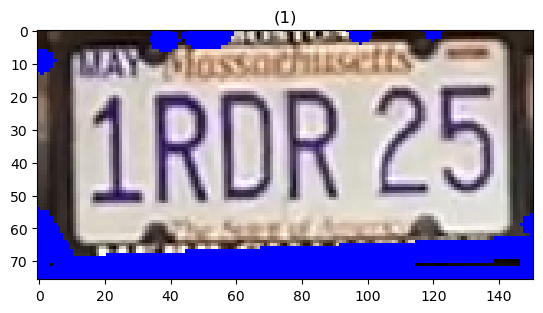

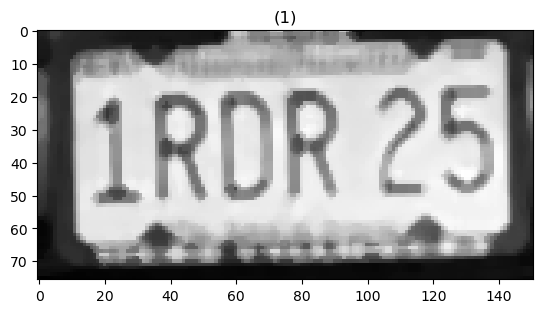

In [73]:
img = cv2.imread('plate.webp', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)

_, threshold = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(
    threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    approx = cv2.approxPolyDP(
        contour, 0.02 * cv2.arcLength(contour, True), True)
    x, y, w, h = cv2.boundingRect(approx)

    if w > 5 and h > 20 and w < 50:
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)

show_images(images=[img])
show_images(images=[gray])
cv2.waitKey(0)
cv2.destroyAllWindows()

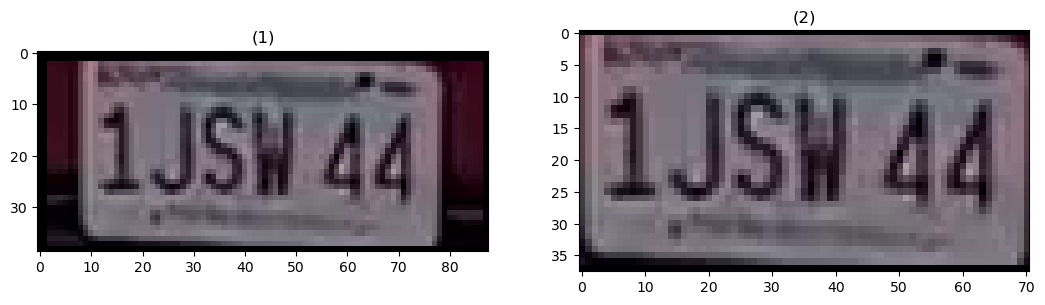

[array([8, 2], dtype=int32), array([10, 36], dtype=int32), array([78, 35], dtype=int32), array([75,  2], dtype=int32)]


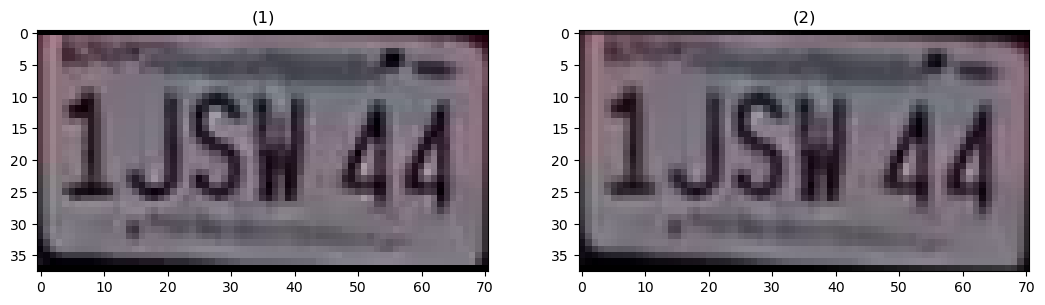

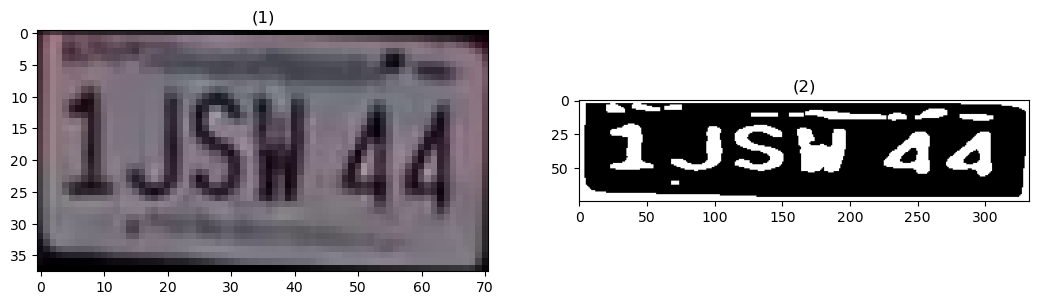

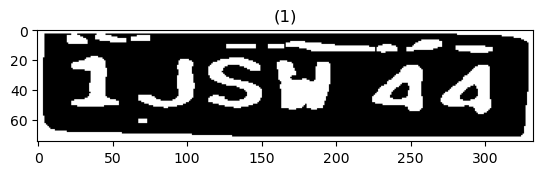

{'min_height': 25.0, 'max_height': 75, 'min_width': 27.75, 'max_width': 111.0}


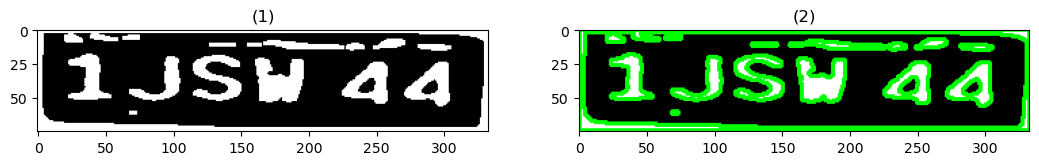

0 0 333 75
3 2 328 71
68 60 6 3
271 24 34 33
283 36 14 13
225 24 34 31
236 35 15 13
161 21 36 33
68 20 38 33
115 19 36 34
23 18 32 34
281 11 25 5
228 10 14 6
155 10 11 3
127 10 20 3
167 8 60 7
248 7 24 8
63 4 13 4


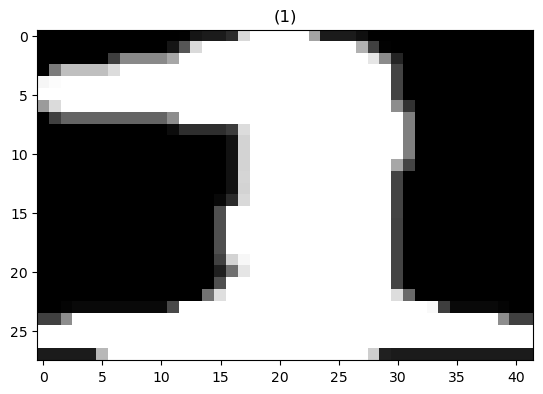

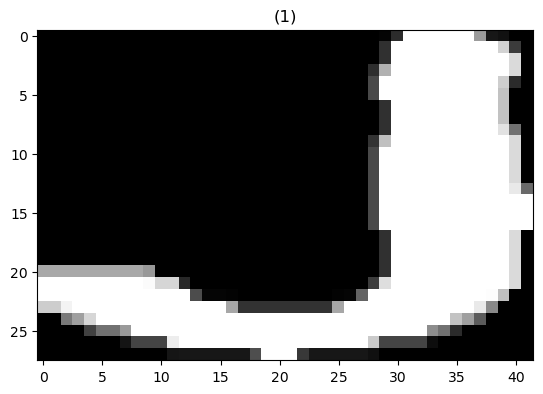

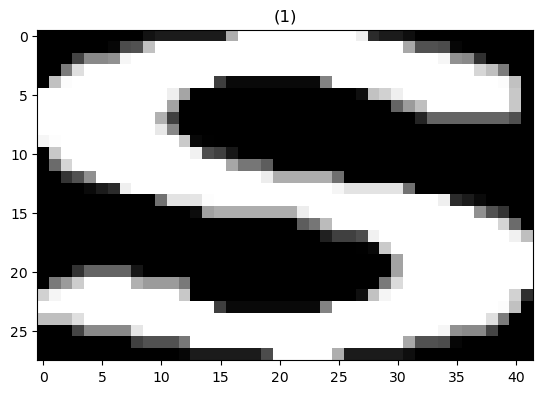

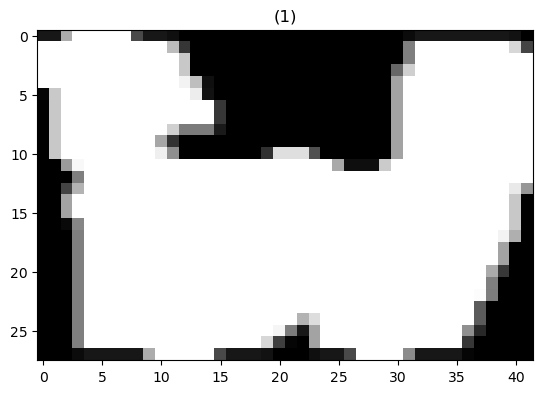

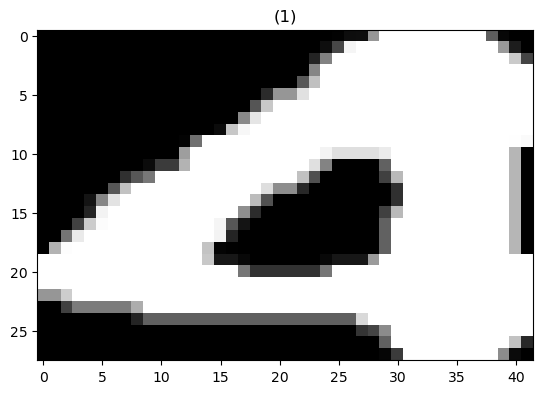

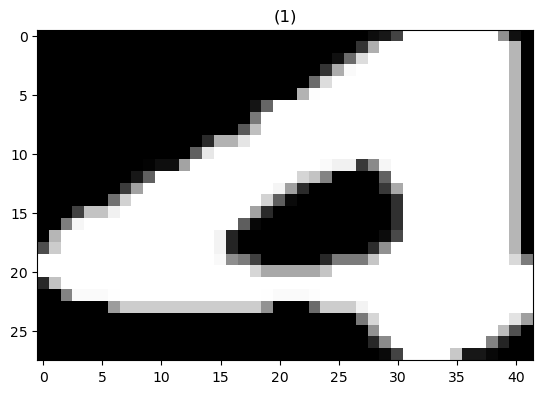

['1' 'J' 'B' 'M' '4' '4']


In [94]:

img = io.imread('plate_4.webp')
contours, ROI = findContour(img)
img = deskew_img(ROI, contour=contours)
chrs, character_contours= segment_characters(img)
character_features=[]
for i,ch in enumerate(chrs):
    show_images([ch])
    ch = cv2.resize(ch,(28, 42))
    character_features.append(extract_combined_features(ch))
predictions = model.predict(character_features)
print(predictions)
